In [2]:
import numpy as np
from qutip import *
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'C:\\Users\\shoha\\Documents\\GitHub\\grimsmo-paper-simulations')

from measurements import *
import matplotlib.pyplot as plt

sys.path.insert(1, 'C:\\Users\\shoha\\PycharmProjects\\bosonicDistillation')

from qudit import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
def add_noise(N, dm_state, tk_B, tk_phi_B):
    E_tk = np.sqrt(tk_B) * tensor(qeye(N),destroy(N))
    E_tk_phi = np.sqrt(tk_phi_B) * tensor(qeye(N),num(N))
    E_0 = tensor(qeye(N),qeye(N)) - 1/2 * E_tk.dag()*E_tk - 1/2 * E_tk_phi.dag() * E_tk_phi
    new_state = E_0.dag() * dm_state * E_0 + E_tk.dag() * dm_state * E_tk + E_tk_phi.dag() * dm_state * E_tk_phi
    return new_state

In [135]:
N=60

coh = coherent(N,3)
pegg_bernett = sum([basis(N, i) for i in range(N)]).unit()

base_state = pegg_bernett
rotation = lambda theta: (theta * 1.0j * num(N)).expm()
entangled_state_2_ebits = (tensor(base_state, base_state) + tensor(rotation(np.pi) * base_state, rotation(np.pi) * base_state)).unit()
entangled_state_4_ebits = (tensor(base_state, base_state) + tensor(rotation(np.pi / 2) * base_state, rotation(np.pi / 2) * base_state)
                           + tensor(rotation(np.pi) * base_state, rotation(np.pi) * base_state)
                           + tensor(rotation(3/2 * np.pi) * base_state, rotation(3 / 2 * np.pi) * base_state)).unit()

starting_state = entangled_state_4_ebits
sig_noise = add_noise(N, ket2dm(starting_state), 0, 0.001).unit()

res_A = 100
res_B = res_A
# the dimensionality of A&B cavities.
d_A = 2
d_B = 2

print("cc")

M_A_class = CanonicalPhaseMeasurement(1 / np.sqrt(N) * base_state, res_A, num(N))
theta_list_A = M_A_class.get_possible_results()
M_B_class = CanonicalPhaseMeasurement(1 / np.sqrt(N) * base_state, res_B, num(N))
theta_list_B = M_B_class.get_possible_results()

print("start")
fid_array = np.zeros([res_A,res_B])
prob_array = np.zeros([res_A,res_B])

ideal_fidelity = fidelity(entangled_state_4_ebits, sig_noise)
print(f"the fidelity to the orginal state: {ideal_fidelity}")

for (i1,x_A) in enumerate(theta_list_A[0:int(len(theta_list_A)/2)]):
    print(i1)

    x_A_plus_pi = theta_list_B[i1 + int(len(theta_list_A)/2)]
    x_A_meas = tensor(M_A_class.POVM_elements[x_A]+M_A_class.POVM_elements[x_A_plus_pi],qeye(N)) # Alice's POVM operator

    state_after_x_A = (x_A_meas.sqrtm()*sig_noise*x_A_meas.sqrtm().dag()).unit()

    prob_A = np.trace(x_A_meas * sig_noise)

    for (i2,x_B) in enumerate(theta_list_B[0:int(len(theta_list_B)/2)]):
        print(i2)
        x_B_plus_pi = theta_list_B[i2 + int(len(theta_list_B)/2)]
        x_B_meas = tensor(qeye(N),M_B_class.POVM_elements[x_B]+M_B_class.POVM_elements[x_B_plus_pi])
        state_after_x_B = (x_B_meas.sqrtm()*state_after_x_A*x_B_meas.sqrtm().dag()).unit()

        prob_B = np.trace(x_B_meas * sig_noise)

        desired_state_1 = tensor(rotation(x_A),rotation(x_B)) * entangled_state_2_ebits
        desired_state_2 = tensor(rotation(x_A),rotation(x_B_plus_pi)) * entangled_state_2_ebits

        fid_array[i1,i2] = max(fidelity(state_after_x_B,ket2dm(desired_state_1)),fidelity(state_after_x_B,ket2dm(desired_state_2)))
        prob_array[i1,i2] = prob_A * prob_B
        print(fid_array[i1,i2])

cc
start


KeyboardInterrupt: 

In [117]:
#plot_wigner(sig_noise.ptrace(1))
fid_array
#fidelity(sig_noise,entangled_state_4_ebits)

array([[0.99725674, 0.99736509, 0.99748303, ..., 0.        , 0.        ,
        0.        ],
       [0.99739336, 0.99754687, 0.99758872, ..., 0.        , 0.        ,
        0.        ],
       [0.99758856, 0.99766353, 0.99736756, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

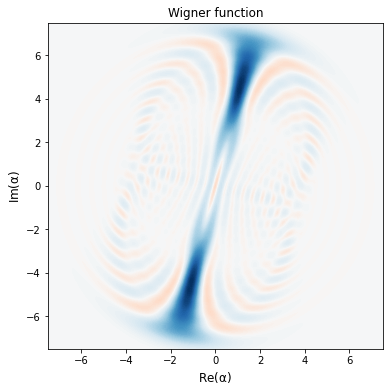

In [131]:
plot_wigner(state_after_x_B.ptrace(1))

(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

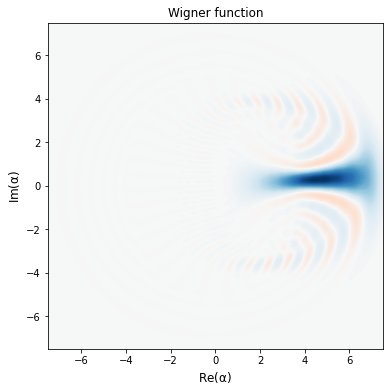

In [104]:
M_class = CanonicalPhaseMeasurement(1 / np.sqrt(N) * sum([basis(N, i) for i in range(N)]), 2, num(N))

plot_wigner((tensor(M_class.POVM_elements[0],qeye(N)) * desired_state).ptrace(0))

(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

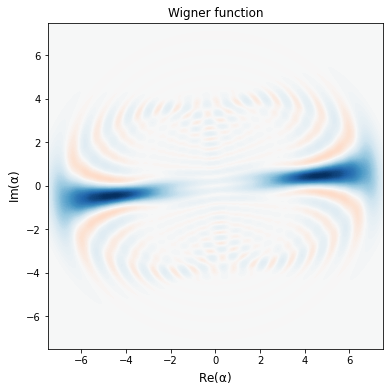

In [78]:
coherent_state_pi_POVM = coh * coh.dag() + rotation(np.pi) * coh * coh.dag() * rotation(np.pi).dag()
x_B_meas_temp = tensor(qeye(N),rotation(0.1) * coherent_state_pi_POVM * rotation(0.1).dag())
plot_wigner((x_B_meas_temp.sqrtm()*state_after_x_A*x_B_meas_temp.sqrtm()).ptrace(0).unit())


In [75]:
desired_state_temp = tensor(rotation(x_A),rotation(0.1)) * (tensor(base_state, coh) + tensor(rotation(np.pi) * base_state, rotation(np.pi) * coh)).unit()
fidelity((x_B_meas_temp.sqrtm()*state_after_x_A*x_B_meas_temp.sqrtm()).unit(),desired_state_temp)

0.7246421751566744

(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

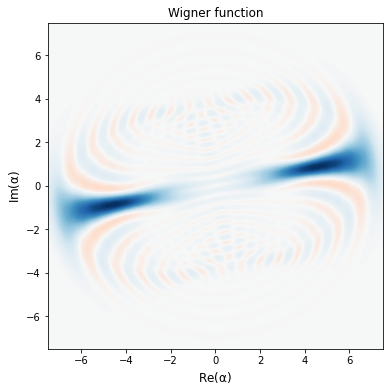

In [77]:
plot_wigner(desired_state_temp.ptrace(0))

In [91]:
display(ket2dm(desired_state))
display(state_after_x_B)
#fidelity(state_after_x_B,ket2dm(desired_state))

Quantum object: dims = [[30, 30], [30, 30]], shape = (900, 900), type = oper, isherm = True
Qobj data =
[[ 0.00222222+0.j          0.        +0.j         -0.00161993-0.00152122j
  ...  0.00222222+0.j          0.        +0.j
  -0.00161993-0.00152122j]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  ...  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [-0.00161993+0.00152122j  0.        +0.j          0.00222222+0.j
  ... -0.00161993+0.00152122j  0.        +0.j
   0.00222222+0.j        ]
 ...
 [ 0.00222222+0.j          0.        +0.j         -0.00161993-0.00152122j
  ...  0.00222222+0.j          0.        +0.j
  -0.00161993-0.00152122j]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  ...  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [-0.00161993+0.00152122j  0.        +0.j          0.00222222+0.j
  ... -0.00161993+0.00152122j  0.        +0.j
   0.00222222+0.j        ]]

Quantum object: dims = [[30, 30], [30, 30]], shape = (900, 900), type = oper, isherm = False
Qobj data =
[[ 0.00157769+0.00000000e+00j  0.        +0.00000000e+00j
  -0.00121992-1.14342790e-03j ... -0.00223544-1.43197196e-03j
   0.        +0.00000000e+00j  0.00068492+2.72463219e-03j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j ...  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [-0.00121992+1.14342864e-03j  0.        +0.00000000e+00j
   0.00177258+0.00000000e+00j ...  0.0027842 -5.07474123e-04j
   0.        +0.00000000e+00j -0.00251422-1.62674275e-03j]
 ...
 [-0.00223544+1.43197188e-03j  0.        +0.00000000e+00j
   0.00278419+5.07472630e-04j ...  0.00504339-8.65961331e-10j
   0.        +0.00000000e+00j -0.00388392-3.63331580e-03j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j ...  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+

Quantum object: dims = [[30, 30], [30, 30]], shape = (900, 900), type = oper, isherm = False
Qobj data =
[[ 5.05430161e-02+6.83934059e-10j  8.22565126e-12-5.92790298e-12j
  -3.51862432e-02-3.30420794e-02j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [-7.63306991e-12+7.81316205e-12j  5.05430162e-02+5.88645311e-10j
  -4.12521610e-11-1.59982311e-11j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [-3.51862408e-02+3.30420819e-02j  4.66882731e-11-1.79137765e-11j
   4.65254146e-02+4.67885848e-09j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 ...
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  4.65254139e-02+4.13675689e-09j
  -1.09872761e-10+4.47247874e-11j -3.51862431e-02-3.30420798e-02j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.0000000

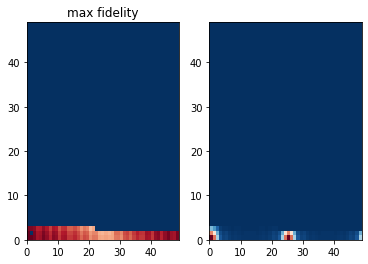

In [133]:
fig, axs = plt.subplots(1, 2)
pc = axs[0].pcolormesh(fid_array[0:int(res_A/2)-1,0:int(res_B/2)-1], cmap='RdBu_r')
#fig.colorbar(pc, ax=axs[0])
axs[0].set_title('max fidelity')
pc = axs[1].pcolormesh(prob_array[0:int(res_A/2)-1,0:int(res_B/2)-1], cmap='RdBu_r')


In [113]:
np.unravel_index(np.argmax(fid_array),fid_array.shape)


(2, 49)

In [129]:
fid_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

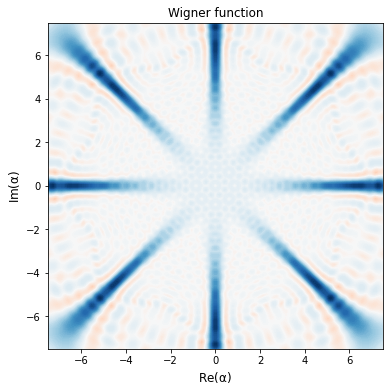

In [138]:
plot_wigner(entangled_state_4_ebits.ptrace(0) + rotation(np.pi / 4) * entangled_state_4_ebits.ptrace(0) * rotation(-np.pi / 4))